In [1]:
!pip install kaggle --quiet

import os
import zipfile
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from google.colab import files

SETUP KAGGLE & DOWNLOAD DATASET

In [2]:
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d uthpalabandara/common-diseases-of-tea-leaves-in-sri-lanka
!unzip -q common-diseases-of-tea-leaves-in-sri-lanka.zip -d tea_disease_dataset


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/uthpalabandara/common-diseases-of-tea-leaves-in-sri-lanka
License(s): MIT
 97% 934M/960M [00:05<00:00, 125MB/s]
100% 960M/960M [00:05<00:00, 169MB/s]


DATA PREPROCESSING

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to dataset (no Train/Test subfolders)
data_dir = "/content/tea_disease_dataset"

# Create image data generators with split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2   # 👈 80% train, 20% validation
)

# Create train generator
train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training'   # 👈 use 80% for training
)

# Create validation generator
test_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # 👈 use 20% for validation
)

num_classes = len(train_data.class_indices)
print(f"✅ Detected {num_classes} classes: {train_data.class_indices}")


Found 960 images belonging to 8 classes.
Found 236 images belonging to 8 classes.
✅ Detected 8 classes: {'Algal Leaf': 0, 'Anthracnose': 1, 'Bird Eye Spot': 2, 'Brown Blight': 3, 'Gray Light': 4, 'Healthy': 5, 'Red Leaf Spot': 6, 'White Spot': 7}


BUILD DENSENET121

In [4]:
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model
for layer in base_model_densenet.layers:
    layer.trainable = False

# Add custom classification head
x = base_model_densenet.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model_densenet = Model(inputs=base_model_densenet.input, outputs=predictions)

# Compile model
model_densenet.compile(optimizer=Adam(learning_rate=0.0005),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

model_densenet.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 32,861,512 (125.36 MB)

 Trainable params: 25,824,008 (98.51 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

TRAIN BASE MODEL

In [5]:
history = model_densenet.fit(
    train_data,
    epochs=25,
    validation_data=test_data
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 256s 8s/step - accuracy: 0.2007 - loss: 7.3477 - val_accuracy: 0.4661 - val_loss: 1.7065
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 232s 8s/step - accuracy: 0.4434 - loss: 2.0946 - val_accuracy: 0.5042 - val_loss: 1.3721
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 230s 8s/step - accuracy: 0.4815 - loss: 1.5162 - val_accuracy: 0.5508 - val_loss: 1.1617
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 227s 8s/step - accuracy: 0.5710 - loss: 1.3158 - val_accuracy: 0.6017 - val_loss: 1.0192
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 279s 9s/step - accuracy: 0.6066 - loss: 1.0923 - val_accuracy: 0.6398 - val_loss: 1.0939
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 233s 8s/step - accuracy: 0.5965 - loss: 1.0515 - val_accuracy: 0.6017 - val_loss: 0.9680
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 239s 8s/step - accuracy: 0.5999 - loss: 1.0577 - val_accuracy: 0.6653 - val_loss: 0.9149
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 232s 8s/step - accuracy: 0.6207 - loss: 1.0039 - val_accuracy: 0.6186 - v

In [6]:
print("\nEvaluating model BEFORE fine-tuning...")
test_loss, test_acc = model_densenet.evaluate(test_data)
print(f"Test Accuracy (Before Fine-Tuning): {test_acc*100:.2f}%")


Evaluating model BEFORE fine-tuning...
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.7089 - loss: 0.7594
Test Accuracy (Before Fine-Tuning): 69.49%


PLOT TRAINING PERFORMANCE

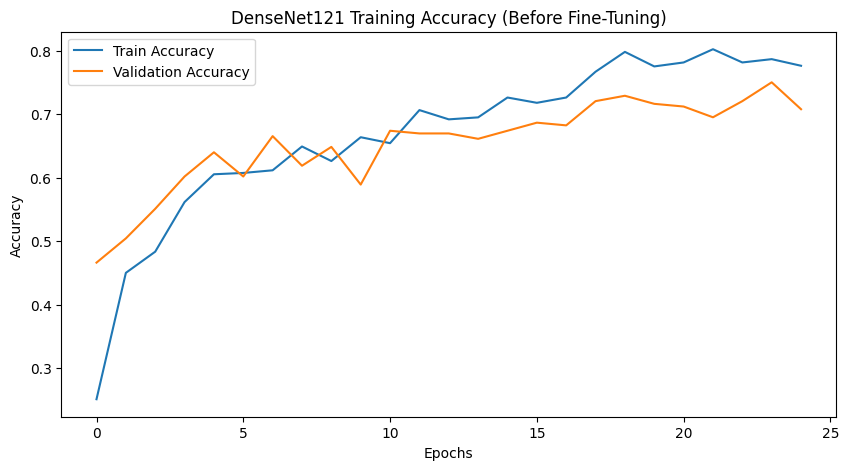

In [7]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('DenseNet121 Training Accuracy (Before Fine-Tuning)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


FINE-TUNE

In [13]:
for layer in base_model_densenet.layers[-40:]:
    layer.trainable = True

model_densenet.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

fine_tune_history = model_densenet.fit(
    train_data,
    epochs=15,
    validation_data=test_data
)

Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 295s 9s/step - accuracy: 0.8203 - loss: 0.4727 - val_accuracy: 0.7754 - val_loss: 0.7771
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 249s 8s/step - accuracy: 0.8568 - loss: 0.4213 - val_accuracy: 0.7076 - val_loss: 0.8082
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 248s 8s/step - accuracy: 0.8574 - loss: 0.3818 - val_accuracy: 0.7246 - val_loss: 0.8224
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 244s 8s/step - accuracy: 0.8711 - loss: 0.3855 - val_accuracy: 0.7542 - val_loss: 0.7457
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 242s 8s/step - accuracy: 0.8437 - loss: 0.4492 - val_accuracy: 0.7331 - val_loss: 0.8018
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 243s 8s/step - accuracy: 0.8289 - loss: 0.4440 - val_accuracy: 0.7246 - val_loss: 0.8197
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 249s 8s/step - accuracy: 0.8463 - loss: 0.4088 - val_accuracy: 0.7331 - val_loss: 0.7141
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 246s 8s/step - accuracy: 0.8603 - loss: 0.3624 - val_accuracy: 0.6992 - v

In [15]:
print("\n Evaluating model AFTER fine-tuning...")
test_loss_ft, test_acc_ft = model_densenet.evaluate(test_data)
print(f" Test Accuracy (After Fine-Tuning): {test_acc_ft*100:.2f}%")


 Evaluating model AFTER fine-tuning...
8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.7178 - loss: 0.7929
 Test Accuracy (After Fine-Tuning): 73.31%


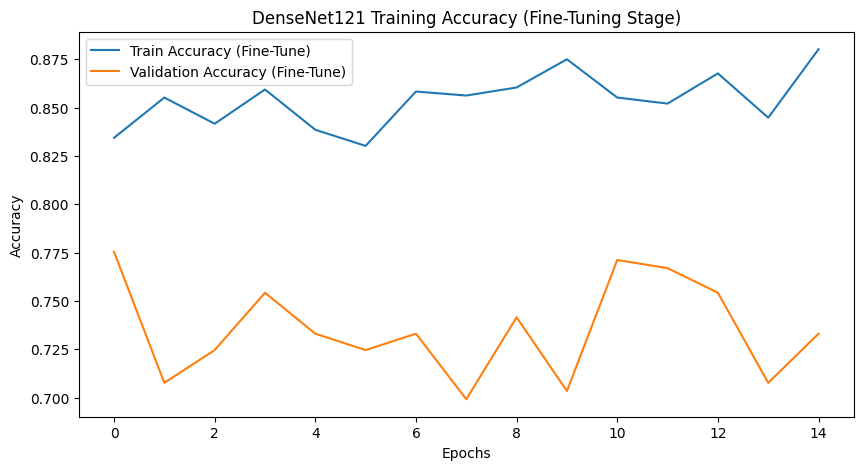

In [16]:
plt.figure(figsize=(10,5))
plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy (Fine-Tune)')
plt.plot(fine_tune_history.history['val_accuracy'], label='Validation Accuracy (Fine-Tune)')
plt.title('DenseNet121 Training Accuracy (Fine-Tuning Stage)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
model_densenet.save('DenseNet121_TeaDisease.h5')
print(" Model saved successfully!")

 Model saved successfully!


 VISUALIZING PREDICTIONS ON TEST SET
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


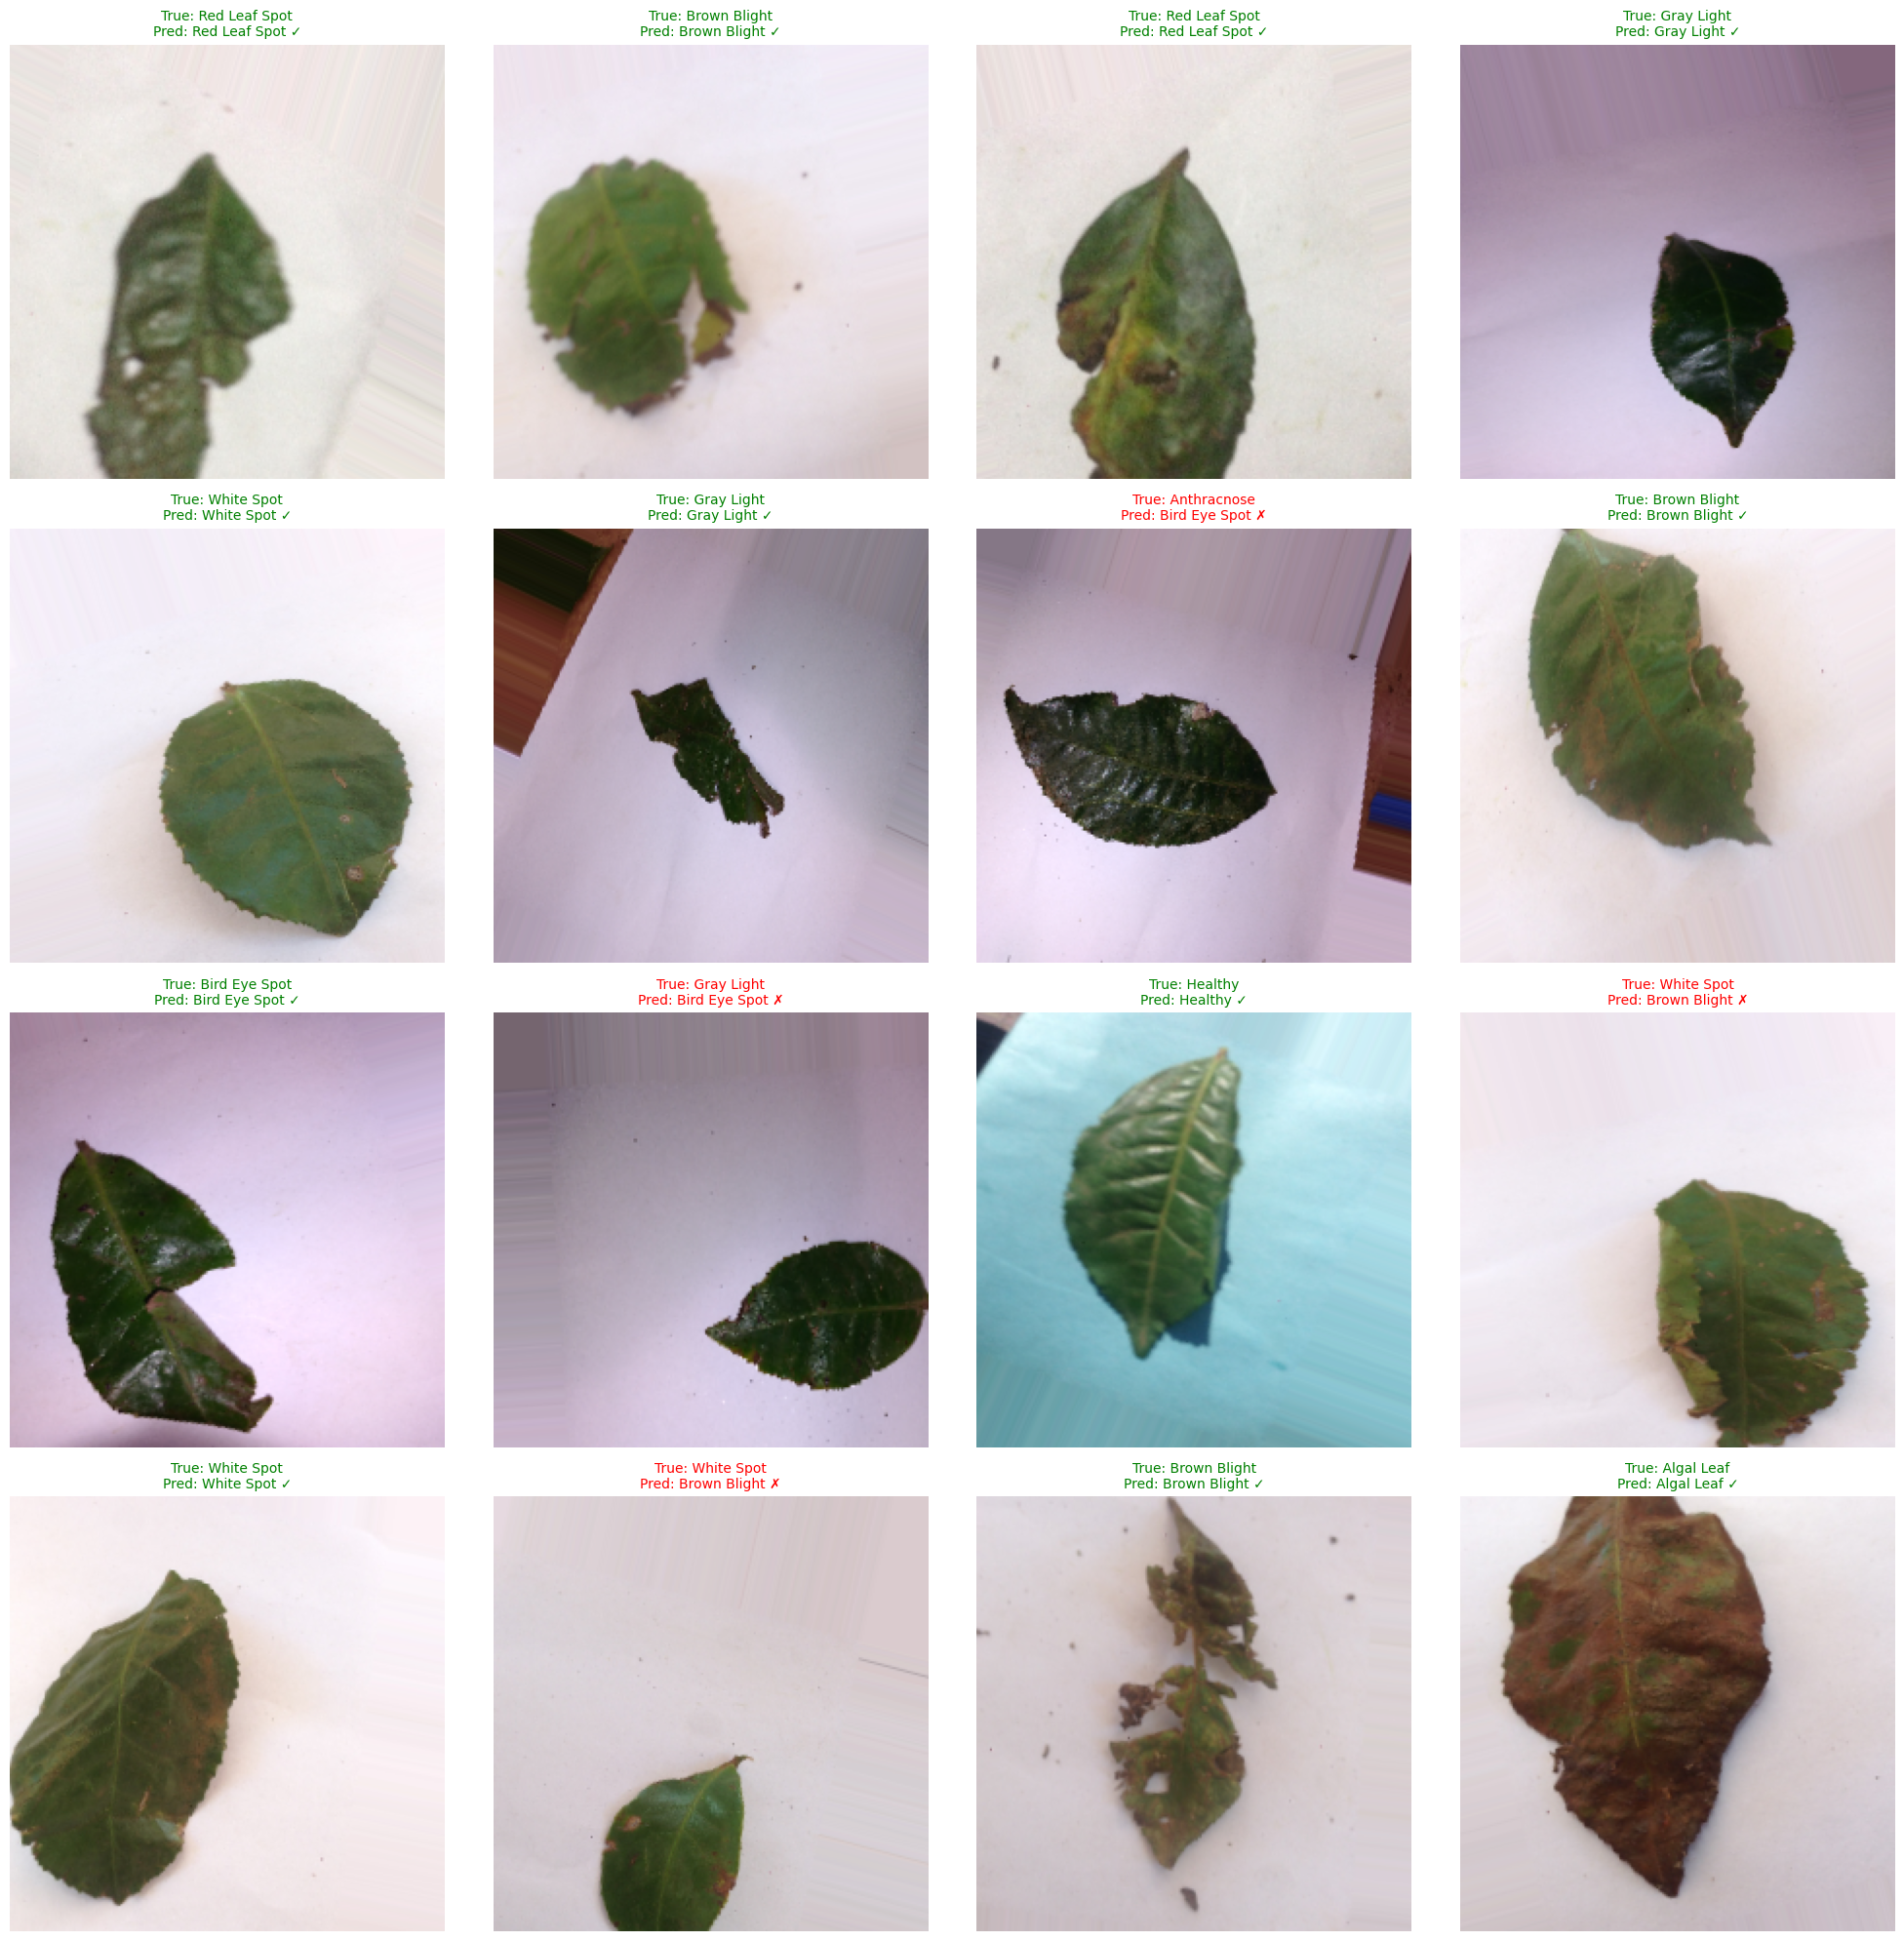


 COMPREHENSIVE MODEL EVALUATION
CLASSIFICATION REPORT
               precision    recall  f1-score   support

   Algal Leaf       0.70      0.77      0.73        30
  Anthracnose       0.79      0.44      0.56        25
Bird Eye Spot       0.67      0.67      0.67        27
 Brown Blight       0.74      0.82      0.78        28
   Gray Light       0.49      0.79      0.60        24
      Healthy       0.95      1.00      0.98        20
Red Leaf Spot       0.95      0.91      0.93        44
   White Spot       0.79      0.61      0.69        38

     accuracy                           0.75       236
    macro avg       0.76      0.75      0.74       236
 weighted avg       0.77      0.75      0.75       236



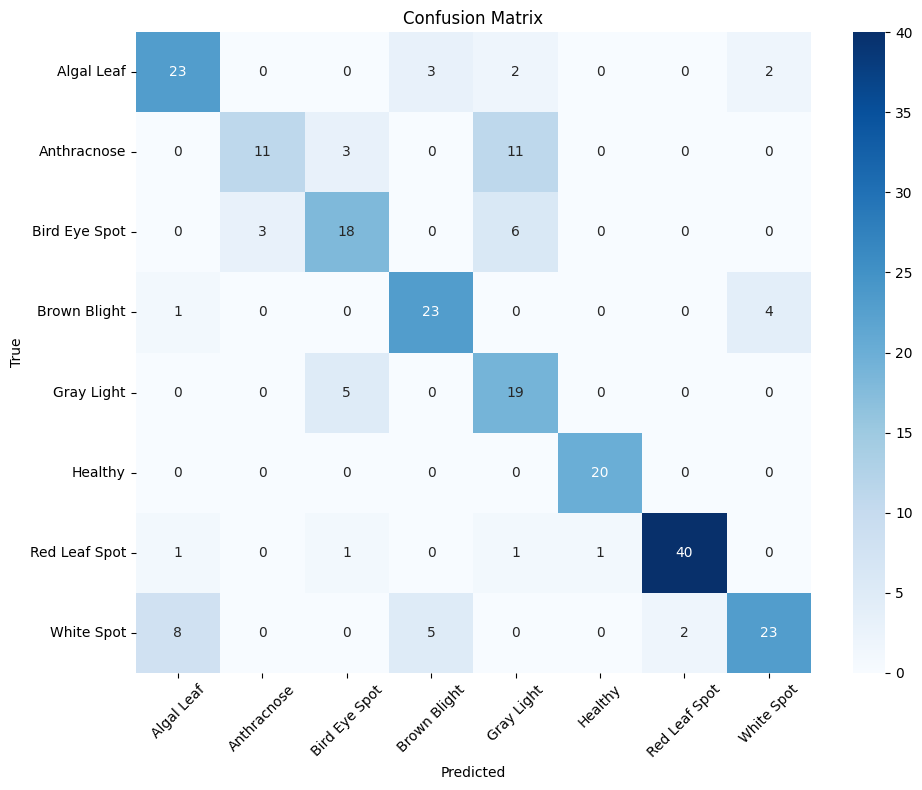

 Overall Test Accuracy: 0.7500 (75.00%)

 TESTING WITH RANDOM IMAGE FROM DATASET


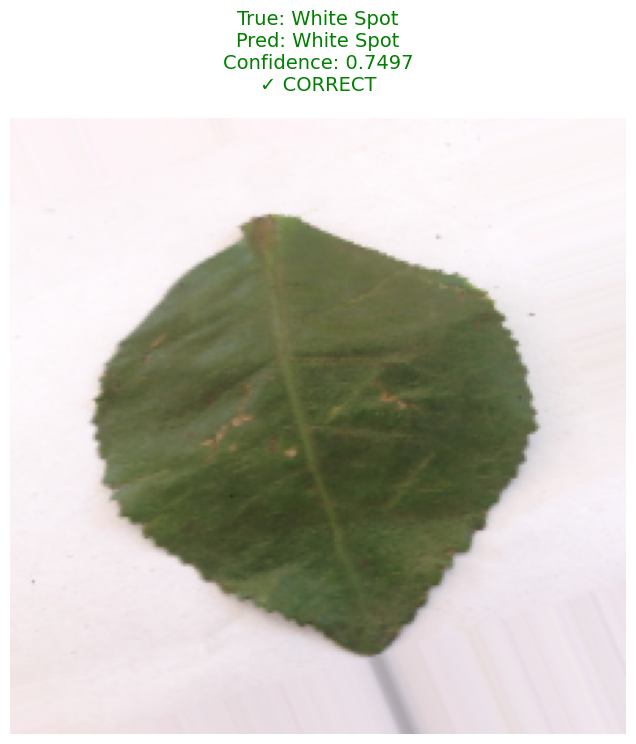

 True label: White Spot
 Predicted: White Spot
 Confidence: 0.7497
 Result: ✓ CORRECT

✅All visualization functions have been added successfully!


In [19]:
# Add these imports at the top with your other imports
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing import image


# VISUALIZE FINAL PREDICTIONS
def visualize_predictions(model, test_generator, num_samples=16):
    """
    Visualize true vs predicted labels for a sample of test images
    """
    # Get a batch of test data
    x_batch, y_batch = next(test_generator)

    # Get predictions
    predictions = model.predict(x_batch)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_batch, axis=1)

    # Get class names
    class_names = list(test_generator.class_indices.keys())

    # Plot the images with true and predicted labels
    plt.figure(figsize=(20, 20))
    for i in range(min(num_samples, len(x_batch))):
        plt.subplot(4, 4, i + 1)
        plt.imshow(x_batch[i])

        # Set title color based on correctness
        if predicted_classes[i] == true_classes[i]:
            color = 'green'
            result = '✓'
        else:
            color = 'red'
            result = '✗'

        plt.title(f'True: {class_names[true_classes[i]]}\nPred: {class_names[predicted_classes[i]]} {result}',
                 color=color, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return predicted_classes, true_classes, class_names

# Generate and display classification report and confusion matrix
def evaluate_model(model, test_generator):
    """
    Generate comprehensive evaluation metrics
    """
    # Get all predictions
    y_pred = []
    y_true = []

    # Reset generator and get all batches
    test_generator.reset()
    for i in range(len(test_generator)):
        x_batch, y_batch = test_generator[i]
        batch_pred = model.predict(x_batch, verbose=0)
        y_pred.extend(np.argmax(batch_pred, axis=1))
        y_true.extend(np.argmax(y_batch, axis=1))

    # Get class names
    class_names = list(test_generator.class_indices.keys())

    # Classification Report
    print("CLASSIFICATION REPORT")
    print("=" * 50)
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Calculate accuracy
    accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
    print(f" Overall Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    return y_true, y_pred

# LOAD AND TEST A SINGLE IMAGE
def predict_single_image(model, image_path, class_names, target_size=(224, 224)):
    """
    Load and predict a single image
    """
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize like training data

    # Make prediction
    prediction = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(prediction[0])
    confidence = np.max(prediction[0])

    # Get class name
    predicted_class = class_names[predicted_class_idx]

    # Display the image with prediction
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f'Prediction: {predicted_class}\nConfidence: {confidence:.4f}',
              fontsize=16, pad=20)
    plt.axis('off')
    plt.show()

    # Print all probabilities
    print(" Prediction Probabilities:")
    for i, (class_name, prob) in enumerate(zip(class_names, prediction[0])):
        if prob > 0.01:  # Only show probabilities above 1%
            print(f"   {class_name}: {prob:.4f}")

    return predicted_class, confidence, prediction

# Test with a random image from the dataset (example)
def test_random_image_from_dataset(model, test_generator):
    """
    Test with a random image from the test dataset
    """
    # Get a random batch
    x_batch, y_batch = next(test_generator)
    random_idx = np.random.randint(0, len(x_batch))

    # Get the image and true label
    test_image = x_batch[random_idx]
    true_label_idx = np.argmax(y_batch[random_idx])

    # Get class names
    class_names = list(test_generator.class_indices.keys())
    true_label = class_names[true_label_idx]

    # Make prediction
    img_array = np.expand_dims(test_image, axis=0)
    prediction = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(prediction[0])
    predicted_class = class_names[predicted_class_idx]
    confidence = np.max(prediction[0])

    # Display results
    plt.figure(figsize=(8, 8))
    plt.imshow(test_image)

    # Color code based on correctness
    if predicted_class == true_label:
        color = 'green'
        result = '✓ CORRECT'
    else:
        color = 'red'
        result = '✗ WRONG'

    plt.title(f'True: {true_label}\nPred: {predicted_class}\nConfidence: {confidence:.4f}\n{result}',
              color=color, fontsize=14, pad=20)
    plt.axis('off')
    plt.show()

    print(f" True label: {true_label}")
    print(f" Predicted: {predicted_class}")
    print(f" Confidence: {confidence:.4f}")
    print(f" Result: {result}")

    return predicted_class, true_label, confidence

# USAGE EXAMPLE - Add this after your model training:

# 1. First, make sure you have trained your model
# history = model_densenet.fit(...)

# 2. Then use the visualization functions:

print(" VISUALIZING PREDICTIONS ON TEST SET")
print("=" * 50)

# Visualize predictions on test set
predicted_classes, true_classes, class_names = visualize_predictions(model_densenet, test_data)

# Comprehensive evaluation
print("\n COMPREHENSIVE MODEL EVALUATION")
print("=" * 50)
y_true, y_pred = evaluate_model(model_densenet, test_data)

# Test with a random image from dataset
print("\n TESTING WITH RANDOM IMAGE FROM DATASET")
print("=" * 50)
pred_class, true_class, confidence = test_random_image_from_dataset(model_densenet, test_data)

# Example for testing a custom image (you'll need to upload an image first)
def test_custom_image():
    """
    Test with a custom uploaded image
    """
    print("\n TESTING WITH CUSTOM IMAGE")
    print("=" * 50)
    print("Please upload an image when prompted...")

    # Upload image
    uploaded = files.upload()

    if uploaded:
        # Get the first uploaded file
        image_path = list(uploaded.keys())[0]
        class_names = list(test_data.class_indices.keys())

        # Make prediction
        predicted_class, confidence, all_predictions = predict_single_image(
            model_densenet, image_path, class_names
        )

        print(f"\n Final Prediction: {predicted_class}")
        print(f" Confidence: {confidence:.4f}")

        return predicted_class, confidence
    else:
        print("No image uploaded!")
        return None, None

# Uncomment the line below to test with a custom uploaded image
# test_custom_image()

print("\n✅All visualization functions have been added successfully!")
